<a href="https://colab.research.google.com/github/francescopatane96/Computer_aided_drug_discovery_kit/blob/main/16_protein_ligand_interactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install nglview redo

In [ ]:
pip install git+https://github.com/volkamerlab/opencadd

In [4]:
pip install mdanalysis

In [ ]:
#Install conda using the new conda-colab library
!pip install -q condacolab
import condacolab
condacolab.install_miniconda()

#Install MGLtools and OpenBabel from
#the bioconda repository
!conda install -c conda-forge -c bioconda mgltools openbabel zlib --yes.

In [24]:
!apt-get install plip

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apbs apbs-data freeglut3 libapbs3 libevdev2 libglu1-mesa libgudev-1.0-0
  libinput-bin libinput10 libmaloc1 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5designer5 libqt5gui5 libqt5help5 libqt5network5
  libqt5opengl5 libqt5printsupport5 libqt5sql5 libqt5sql5-sqlite libqt5svg5
  libqt5test5 libqt5widgets5 libqt5xml5 libwacom-bin libwacom-common libwacom9
  libxcb-icccm4 libxcb-image0 libxcb-keysyms1 libxcb-render-util0 libxcb-util1
  libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1 libxkbcommon-x11-0 pymol
  pymol-data python3-bs4 python3-chardet python3-html5lib python3-lxml
  python3-numpy python3-openbabel python3-opengl python3-pymol python3-pyqt5
  python3-pyqt5.qtopengl python3-pyqt5.sip python3-soupsieve
  python3-webencodings qt5-g

In [25]:
# Import libraries
from pathlib import Path
import time
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import nglview as nv
import openbabel
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from plip.structure.preparation import PDBComplex
from plip.exchange.report import BindingSiteReport

from opencadd.structure.core import Structure

In [2]:
pdb_id = "3poz"

In [3]:
pdb_file = Structure.from_pdbid(pdb_id)
# Download it to file for later use
pdb_file.write(f"{pdb_id}.pdb")

In [5]:
from google.colab import output
output.enable_custom_widget_manager()

In [6]:
ngl_viewer = nv.show_pdbid(pdb_id)
# add the ligands
ngl_viewer.add_representation(repr_type="ball+stick", selection="hetero and not water")
# center view on binding site
ngl_viewer.center("ligand")
ngl_viewer

NGLWidget()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [7]:
def retrieve_plip_interactions(pdb_file):
    """
    Retrieves the interactions from PLIP.

    Parameters
    ----------
    pdb_file :
        The PDB file of the complex.

    Returns
    -------
    dict :
        A dictionary of the binding sites and the interactions.
    """
    protlig = PDBComplex()
    protlig.load_pdb(pdb_file)  # load the pdb file
    for ligand in protlig.ligands:
        protlig.characterize_complex(ligand)  # find ligands and analyze interactions
    sites = {}
    # loop over binding sites
    for key, site in sorted(protlig.interaction_sets.items()):
        binding_site = BindingSiteReport(site)  # collect data about interactions
        # tuples of *_features and *_info will be converted to pandas DataFrame
        keys = (
            "hydrophobic",
            "hbond",
            "waterbridge",
            "saltbridge",
            "pistacking",
            "pication",
            "halogen",
            "metal",
        )
        # interactions is a dictionary which contains relevant information for each
        # of the possible interactions: hydrophobic, hbond, etc. in the considered
        # binding site. Each interaction contains a list with
        # 1. the features of that interaction, e.g. for hydrophobic:
        # ('RESNR', 'RESTYPE', ..., 'LIGCOO', 'PROTCOO')
        # 2. information for each of these features, e.g. for hydrophobic
        # (residue nb, residue type,..., ligand atom 3D coord., protein atom 3D coord.)
        interactions = {
            k: [getattr(binding_site, k + "_features")] + getattr(binding_site, k + "_info")
            for k in keys
        }
        sites[key] = interactions
    return sites

In [26]:
interactions_by_site = retrieve_plip_interactions(f"{pdb_id}.pdb")

In [27]:
print(
    f"Number of binding sites detected in {pdb_id} : "
    f"{len(interactions_by_site)}\n"
    f"with {interactions_by_site.keys()}"
)
# NBVAL_CHECK_OUTPUT

Number of binding sites detected in 3poz : 4
with dict_keys(['03P:X:1023', 'SO4:X:1', 'SO4:X:2', 'SO4:X:3'])


In [28]:
index_of_selected_site = 0
selected_site = list(interactions_by_site.keys())[index_of_selected_site]
print(selected_site)

03P:X:1023


In [29]:
def create_df_from_binding_site(selected_site_interactions, interaction_type="hbond"):
    """
    Creates a data frame from a binding site and interaction type.

    Parameters
    ----------
    selected_site_interactions : dict
        Precaluclated interactions from PLIP for the selected site
    interaction_type : str
        The interaction type of interest (default set to hydrogen bond).

    Returns
    -------
    pd.DataFrame :
        DataFrame with information retrieved from PLIP.
    """

    # check if interaction type is valid:
    valid_types = [
        "hydrophobic",
        "hbond",
        "waterbridge",
        "saltbridge",
        "pistacking",
        "pication",
        "halogen",
        "metal",
    ]

    if interaction_type not in valid_types:
        print("!!! Wrong interaction type specified. Hbond is chosen by default!!!\n")
        interaction_type = "hbond"

    df = pd.DataFrame.from_records(
        # data is stored AFTER the column names
        selected_site_interactions[interaction_type][1:],
        # column names are always the first element
        columns=selected_site_interactions[interaction_type][0],
    )
    return df

In [30]:
create_df_from_binding_site(interactions_by_site[selected_site], interaction_type="hydrophobic")

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST,LIGCARBONIDX,PROTCARBONIDX,LIGCOO,PROTCOO
0,745,LYS,X,1023,03P,X,3.91,2398,320,"(18.317, 32.25, 10.052)","(20.469, 34.989, 8.267)"
1,788,LEU,X,1023,03P,X,3.89,2396,593,"(15.676, 34.766, 8.319)","(16.314, 35.031, 4.495)"
2,788,LEU,X,1023,03P,X,3.66,2383,595,"(18.404, 30.743, 6.486)","(18.317, 33.573, 4.169)"
3,854,THR,X,1023,03P,X,3.82,2382,1138,"(18.135, 32.543, 11.422)","(17.798, 28.992, 12.797)"
4,858,LEU,X,1023,03P,X,3.93,2383,1167,"(18.404, 30.743, 6.486)","(22.084, 30.736, 5.093)"
5,745,LYS,X,1023,03P,X,3.53,2396,318,"(15.676, 34.766, 8.319)","(18.634, 36.648, 7.936)"
6,790,THR,X,1023,03P,X,3.48,2396,611,"(15.676, 34.766, 8.319)","(12.875, 33.449, 9.914)"


In [31]:
create_df_from_binding_site(interactions_by_site[selected_site], interaction_type="hbond")

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST_H-A,DIST_D-A,DON_ANGLE,PROTISDON,DONORIDX,DONORTYPE,ACCEPTORIDX,ACCEPTORTYPE,LIGCOO,PROTCOO
0,793,MET,X,1023,03P,X,False,2.01,2.96,163.57,True,629,Nam,2404,Nar,"(13.371, 34.064, 15.005)","(10.667, 33.654, 16.145)"


In [32]:
create_df_from_binding_site(interactions_by_site[selected_site], interaction_type="halogen")

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST,DON_ANGLE,ACC_ANGLE,DON_IDX,DONORTYPE,ACC_IDX,ACCEPTORTYPE,LIGCOO,PROTCOO
0,766,MET,X,1023,03P,X,False,3.60,167.05,118.86,2389,F,431,O2,"(12.164, 26.835, 3.777)","(14.283, 28.118, 6.395)"
1,790,THR,X,1023,03P,X,True,3.47,171.27,103.84,2388,F,610,O3,"(11.467, 31.629, 9.124)","(13.867, 29.356, 8.056)"


In [33]:
color_map = {
    "hydrophobic": [0.90, 0.10, 0.29],
    "hbond": [0.26, 0.83, 0.96],
    "waterbridge": [1.00, 0.88, 0.10],
    "saltbridge": [0.67, 1.00, 0.76],
    "pistacking": [0.75, 0.94, 0.27],
    "pication": [0.27, 0.60, 0.56],
    "halogen": [0.94, 0.20, 0.90],
    "metal": [0.90, 0.75, 1.00],
}

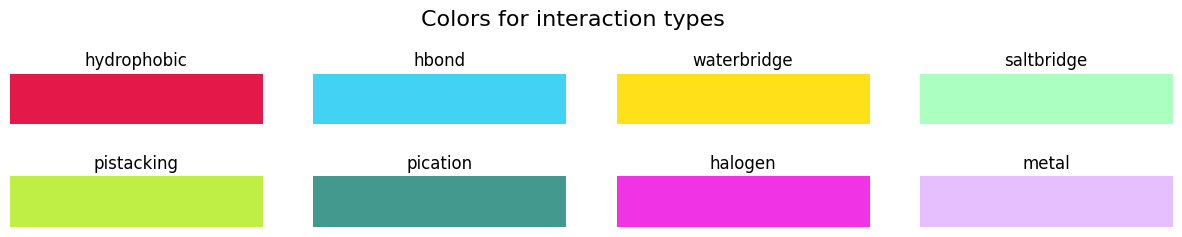

In [34]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 2))
plt.subplots_adjust(hspace=1)
fig.suptitle("Colors for interaction types", size=16, y=1.2)

for ax, (interaction, color) in zip(fig.axes, color_map.items()):
    ax.imshow(np.zeros((1, 5)), cmap=colors.ListedColormap(color_map[interaction]))
    ax.set_title(interaction, loc="center")
    ax.set_axis_off()
plt.show()

In [35]:
def show_interactions_3d(
    pdb_id, selected_site_interactions, highlight_interaction_colors=color_map
):
    """
    3D visualization of protein-ligand interactions.

    Parameters
    ----------
    pdb_id : str
        The pdb ID of interest.
    selected_site_interactions : dict
        Precaluclated interactions from PLIP for the selected site
    highlight_interaction_colors : dict
        The colors used to highlight the different interaction types.

    Returns
    -------
    NGL viewer with explicit interactions given by PLIP.
    """

    # Create NGLviewer
    viewer = nv.NGLWidget(height="600px", default=True, gui=True)
    # Add protein
    prot_component = viewer.add_pdbid(pdb_id)
    # Add the ligands
    viewer.add_representation(repr_type="ball+stick", selection="hetero and not water")

    interacting_residues = []
    for interaction_type, interaction_list in selected_site_interactions.items():
        color = highlight_interaction_colors[interaction_type]
        if len(interaction_list) == 1:
            continue
        df_interactions = pd.DataFrame.from_records(
            interaction_list[1:], columns=interaction_list[0]
        )
        for _, interaction in df_interactions.iterrows():
            name = interaction_type
            # add cylinder between ligand and protein coordinate
            viewer.shape.add_cylinder(
                interaction["LIGCOO"],
                interaction["PROTCOO"],
                color,
                [0.1],
                name,
            )
            interacting_residues.append(interaction["RESNR"])
    # Display interacting residues
    res_sele = " or ".join([f"({r} and not _H)" for r in interacting_residues])
    res_sele_nc = " or ".join([f"({r} and ((_O) or (_N) or (_S)))" for r in interacting_residues])
    prot_component.add_ball_and_stick(sele=res_sele, colorScheme="chainindex", aspectRatio=1.5)
    prot_component.add_ball_and_stick(sele=res_sele_nc, colorScheme="element", aspectRatio=1.5)
    # Center on ligand
    viewer.center("ligand")
    return viewer

In [36]:
viewer_3d = show_interactions_3d(pdb_id, interactions_by_site[selected_site])
viewer_3d

NGLWidget()